In [1]:
# Import necessary components 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from matplotlib import pyplot
from math import sqrt
from numpy import mean
from numpy import std
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [2]:
# Import SARS and COVID csv files
# Only import 'date' and 'cumulative_cases' columns
canada_sars = pd.read_csv('./data/sars_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])
canada_covid = pd.read_csv('./data/covid_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])

# Given input data and how many training data it would be used,
# Split the input data into train and test data
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# Convert into data
data_train = canada_sars.values
data_test = canada_covid.values

In [3]:
# Defining a few functions that is needed
# These functions are used for RMSE calculation as well as walk-forward validation

# Shift data for supervised learning, one-step forecast
def shift_data(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    col = list()
    
    # Create two seperate columns, one original, one shifted forward
    
    # Input- nonchanged
    for i in range(n_in, 0, -1):
        col.append(df.shift(i))
        
    # Output- shifted forward 1 
    for i in range(0, n_out):
        col.append(df.shift(-i))
        
    result = pd.concat(col, axis=1)
    result.dropna(inplace=True)

    return result.values

def rmse_error(actual, predicted):
    # Print acutal and predicted of last data value
    print('Actual: ' + f'{actual[len(actual) - 1][0]}')
    print('Predicted: %.0f' % (predicted[len(predicted) - 1][0]))
    
    # Display plot of actual vs predicted values
    pyplot.plot(actual, label='Actual')
    pyplot.plot(predicted, label='Predicted')
    pyplot.legend()
    pyplot.show()
    
    # Return mean squared error
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train_data, test_data, cfg):
    prediction = list()
    
    # fit model
    model = fit_model(train_data, cfg)
    
    # seed history with training data
    history = [x for x in train_data]
    
    for i in range(len(test_data)):
        # fit model and make forecast for history
        yhat = predict_model(model, history,cfg)
        
        # store forecast
        prediction.append(yhat)
        # add observation to history for next loop
        history.append(test_data[i]);
    
    # estimate error
    error = rmse_error(test_data, prediction)
    print('Error: ' + '%.3f' % error)
    return error

def repeat_eval(train_data, test_data, cfg, repeats):
    scores = list()
    
    for i in range(repeats):
        print('\nIteration: %.0f' % (i + 1))
        scores.append(walk_forward_validation(train_data, test_data, cfg))
        
    return scores

def summarize(name, scores):
    score_mean, score_std = mean(scores), std(scores)
    print('\n%s: %.3f RMSE (+/- %.3f)' % (name, score_mean, score_std))
    
    pyplot.boxplot(score_list)
    pyplot.show()


Iteration: 1
Actual: 68848
Predicted: 69201


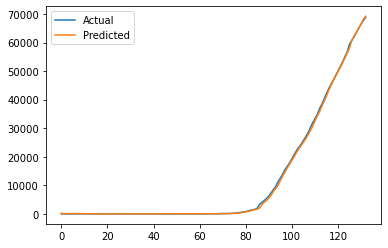

Error: 420.456

Iteration: 2
Actual: 68848
Predicted: 67164


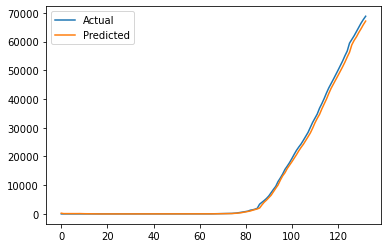

Error: 952.858

Iteration: 3
Actual: 68848
Predicted: 68071


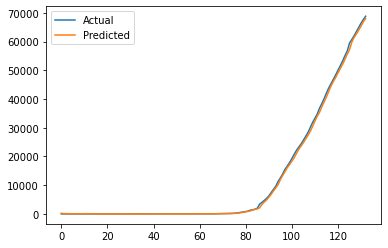

Error: 582.886

Iteration: 4
Actual: 68848
Predicted: 71237


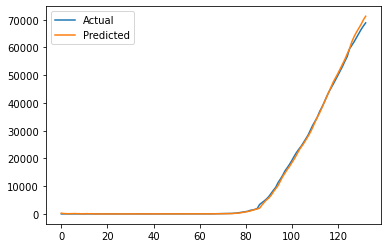

Error: 575.666

Iteration: 5
Actual: 68848
Predicted: 67691


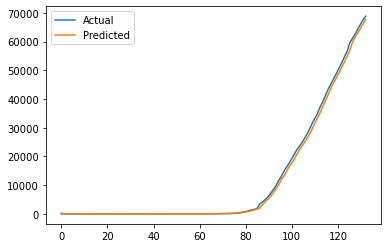

Error: 892.207

Iteration: 6
Actual: 68848
Predicted: 66220


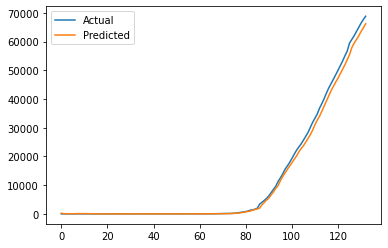

Error: 1326.506

Iteration: 7
Actual: 68848
Predicted: 69277


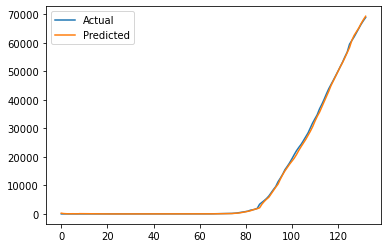

Error: 421.714

Iteration: 8
Actual: 68848
Predicted: 68130


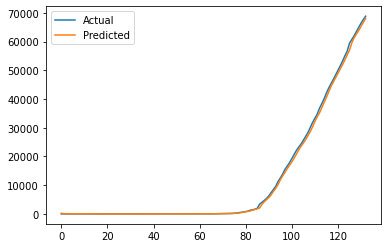

Error: 660.340

Iteration: 9
Actual: 68848
Predicted: 66716


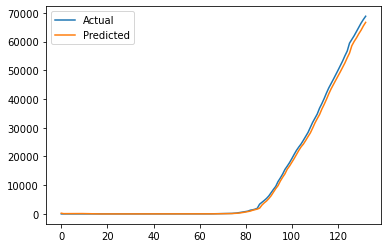

Error: 1056.321

Iteration: 10
Actual: 68848
Predicted: 67698


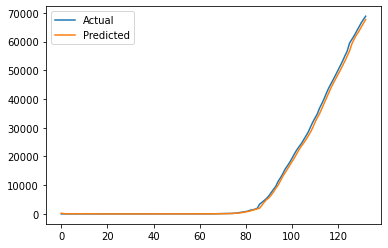

Error: 825.849

MLP: 771.480 RMSE (+/- 277.747)


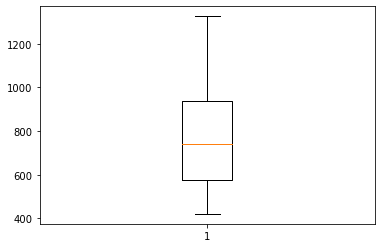

In [4]:
# Building the Multilayer Perceptron model using the following configuration
# n_input: The number of lag observations to use as input to the model
# n_nodes: The number of nodes to use in the hidden layer
# n_epochs: The number of times to expose the model to the whole training dataset
# n_batch: The number of samples within an epoch after which the weights are updated

# Define and then fit the model
# Given the training data, and configuration, this function fits a model
def fit_model(train, config):
    n_input, n_nodes, n_epochs, n_batch = config
    data = shift_data(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# Predict the model
# Given a model, the history, and configuration, this function predicts a model
def predict_model(model, history, config):
    n_input, _, _, _ = config
    x_input = array(history[-n_input:]).reshape(1, n_input)
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# After defining the two functions needed to fit and predict the model, define the configuration
config = [14, 100, 100, 1]

# Create and fit model
# Error is calculate throughout the entire prediction period
score_list = repeat_eval(data_train, data_test, config, 10)
summarize('MLP', score_list)